In [261]:
from problexity import ComplexityCalculator, classification
from problexity.classification import *
from sklearn.decomposition import PCA
import numpy as np
from generator.ConditionalEvidenceStream import ConditionalEvidenceStream
from generator.concepts import concept_proba
from generator.utils import make_condition_map, mix_to_factor
import torch
import torchvision
import json

np.random.seed(1223)
torch.manual_seed(15553)
torch.set_num_threads(1)

# Prepare stream data
stream_data = torchvision.datasets.MNIST('./files/', 
                                  train=True,
                                  download=True)

X = torch.tensor(stream_data.data)/255
y = stream_data.targets.numpy()


/var/folders/md/9788g9qs5h77d4hrzh39xpkc0000gn/T/ipykernel_63342/4049286905.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(stream_data.data)/255


In [262]:

X_pca = PCA(n_components=0.9).fit_transform(X.reshape(X.shape[0],-1))
X_pca -= np.mean(X_pca, axis=0)
X_pca /= np.std(X_pca, axis=0)



In [263]:

# setup
n_chunks = 500
chunk_size = 150

# One stream

factor = mix_to_factor(X_pca)

condition_map = make_condition_map(n_cycles=3,
                                n_concepts=100,
                                factor=factor,
                                factor_range=(0.1,0.9))

cp = concept_proba(n_concepts=100,
                            n_chunks=n_chunks,
                            normalize=True,
                            mode = 'linear')

stream = ConditionalEvidenceStream(X, y,
                                condition_map.T,
                                cp,
                                chunk_size=chunk_size,
                                fragile=False,
                                random_state=1223)



In [284]:
from methods.architectures import CNN1_5_Network, CNN
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# CLF
clf = CNN(architecure=CNN1_5_Network())
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=1e-2)

# DATA
train_data = torchvision.datasets.MNIST('./files/', 
                                  train=False, #Tak.
                                  download=True)

X = (torch.tensor(train_data.data)/255).to(torch.float)
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
y = train_data.targets
print(X.shape)
print(y.shape)


dataset = TensorDataset(torch.Tensor(X),torch.Tensor(y))
dataloader = DataLoader(dataset, batch_size=64)

# TRAINING
for e in range(10):
    if e==0:
        clf.custom_train(dataloader, loss_fn, optimizer)
    else:

        proba = nn.Softmax(dim=1)(clf(X))
        max_proba = torch.max(proba, dim=1)[0] 
        mean_proba = torch.mean(max_proba).detach().numpy() # średnie wsparcie decyzyjne
        
        print(e, mean_proba)
        
        clf.custom_train(dataloader, loss_fn, optimizer)
    


/var/folders/md/9788g9qs5h77d4hrzh39xpkc0000gn/T/ipykernel_63342/4131468797.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = (torch.tensor(train_data.data)/255).to(torch.float)


torch.Size([10000, 1, 28, 28])
torch.Size([10000])
1 0.42880756
2 0.73331016
3 0.8038436
4 0.83410764
5 0.85111123
6 0.8621246
7 0.86988634
8 0.8758288
9 0.880508


In [285]:
# Prepare stream data
stream_data = torchvision.datasets.MNIST('./files/', 
                                  train=True,
                                  download=True)

X = torch.tensor(stream_data.data)/255
y = stream_data.targets.numpy()

# setup
n_chunks = 500
chunk_size = 150

# One stream

factor = mix_to_factor(X_pca)

condition_map = make_condition_map(n_cycles=3,
                                n_concepts=100,
                                factor=factor,
                                factor_range=(0.1,0.9))

cp = concept_proba(n_concepts=100,
                            n_chunks=n_chunks,
                            normalize=True,
                            mode = 'linear')

stream = ConditionalEvidenceStream(X, y,
                                condition_map.T,
                                cp,
                                chunk_size=chunk_size,
                                fragile=False,
                                random_state=1223)

/var/folders/md/9788g9qs5h77d4hrzh39xpkc0000gn/T/ipykernel_63342/2620065466.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(stream_data.data)/255


In [286]:
accs = []

from sklearn.metrics import accuracy_score

for c in range(n_chunks):
    _X, _y = stream.get_chunk()
    _X = _X.reshape(_X.shape[0], 1, _X.shape[1], _X.shape[2])

    
    proba = nn.Softmax(dim=1)(clf(_X))
    p = torch.argmax(proba, dim=1)
    
    accs.append(accuracy_score(_y,p)) 


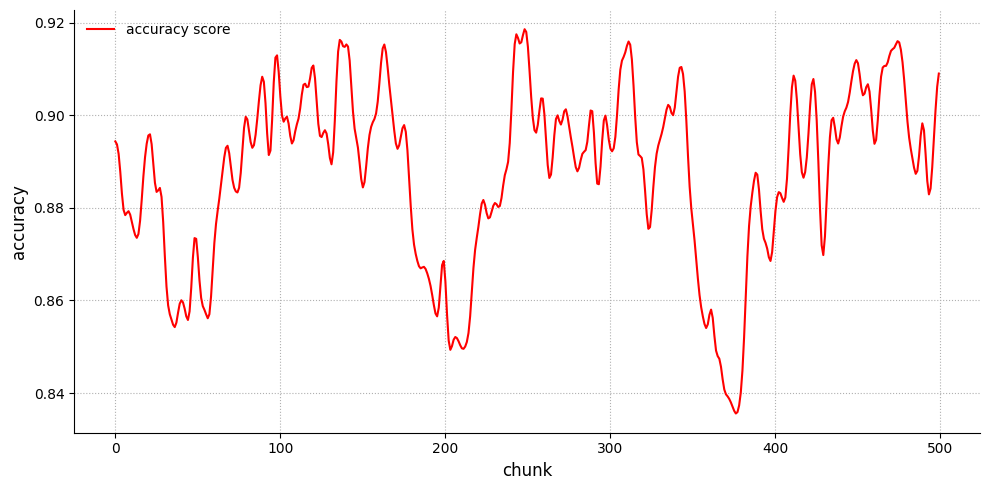

In [287]:
from scipy.ndimage import gaussian_filter1d
fig, ax = plt.subplots(1,1,figsize=(10,5))
s = 2

ax.plot(gaussian_filter1d(accs,s), c='r', label='accuracy score')
# ax.plot(gaussian_filter1d(num_errors,s), c='r', label='number of errors')
    
ax.grid(ls=':')
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('chunk', fontsize=12)
ax.set_ylabel('accuracy', fontsize=12)

plt.tight_layout()

In [296]:
prosty = np.argmax(accs)
trudny = np.argmin(accs)

In [297]:

# setup
n_chunks = 500
chunk_size = 150

# One stream

factor = mix_to_factor(X_pca)

condition_map = make_condition_map(n_cycles=3,
                                n_concepts=100,
                                factor=factor,
                                factor_range=(0.1,0.9))

cp = concept_proba(n_concepts=100,
                            n_chunks=n_chunks,
                            normalize=True,
                            mode = 'linear')

stream = ConditionalEvidenceStream(X, y,
                                condition_map.T,
                                cp,
                                chunk_size=chunk_size,
                                fragile=False,
                                random_state=1223)

In [298]:
cc = ComplexityCalculator()

/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. S

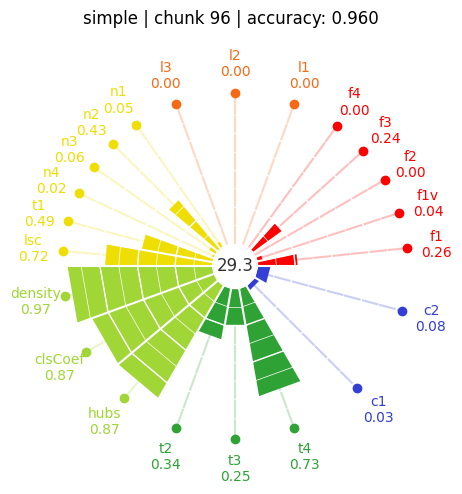

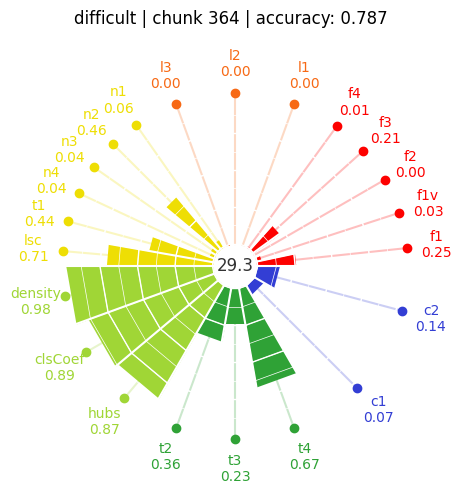

In [299]:
fig_simple = plt.figure(figsize=(5,5))
fig_simple.suptitle('simple | chunk %i | accuracy: %.3f' %(prosty, accs[prosty]))
fig_diff = plt.figure(figsize=(5,5))
fig_diff.suptitle('difficult | chunk %i | accuracy: %.3f' %(trudny, accs[trudny]))

for c in range(n_chunks):
    _X, _y = stream.get_chunk()
    _X = _X.reshape(chunk_size, -1)
    if c==0:
        pca = PCA(n_components=10)
        _X = pca.fit_transform(_X, y)
    else:
        _X = pca.transform(_X)
    
    if c==prosty:
        #plot
        cc.fit(_X, _y)
        cc.plot(fig_simple)
        
    if c==trudny:
        #plot
        cc.fit(_X, _y)
        cc.plot(fig_diff)
        
fig_simple.tight_layout()
fig_simple.savefig('simple_m.png')
fig_simple.savefig('simple_m.eps')

fig_diff.tight_layout()
fig_diff.savefig('diff_m.png')
fig_diff.savefig('diff_m.eps')